In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import optuna
import joblib

import warnings
warnings.filterwarnings('ignore')


c:\Users\Asus\anaconda3\envs\gosoft\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Loading

In [3]:
# Load the datasets
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Display basic information about the datasets
print("Training Dataset Info:")
print(df_train.info())
print("\nTest Dataset Info:")
print(df_test.info())

# Check for missing values
print("\nMissing values in Training Dataset:")
print(df_train.isnull().sum())
print("\nMissing values in Test Dataset:")
print(df_test.isnull().sum())

# Display summary statistics
print("\nTraining Dataset Summary Statistics:")
print(df_train.describe())

# Check unique values in categorical columns
print("\nUnique values in each column:")
for col in df_train.columns:
    print(f"\n{col}:")
    print(f"Number of unique values: {df_train[col].nunique()}")
    if df_train[col].dtype == 'object' or df_train[col].nunique() < 10:
        print("Sample values:", df_train[col].unique()[:5])

# Check for outliers in sales
Q1 = df_train['sales'].quantile(0.25)
Q3 = df_train['sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_train[(df_train['sales'] < (Q1 - 1.5 * IQR)) | 
                    (df_train['sales'] > (Q3 + 1.5 * IQR))]
print(f"\nNumber of outliers in sales: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers)/len(df_train))*100:.2f}%")


Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None

Missing values in Training Dataset:
date     0
store    0
item     0
sales    0
dtype: int64

Missing values in Test Dataset:
id       0
date     0
store    0
item     0
dtype: int64

Train

# 2. Data Preprocessing

In [4]:
# Convert date columns to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Sort data by date
df_train = df_train.sort_values('date')
df_test = df_test.sort_values('date')

# Label encode categorical variables
le_store = LabelEncoder()
le_item = LabelEncoder()

df_train['store_encoded'] = le_store.fit_transform(df_train['store'])
df_train['item_encoded'] = le_item.fit_transform(df_train['item'])
df_test['store_encoded'] = le_store.transform(df_test['store'])
df_test['item_encoded'] = le_item.transform(df_test['item'])


# 3. Data Visualization

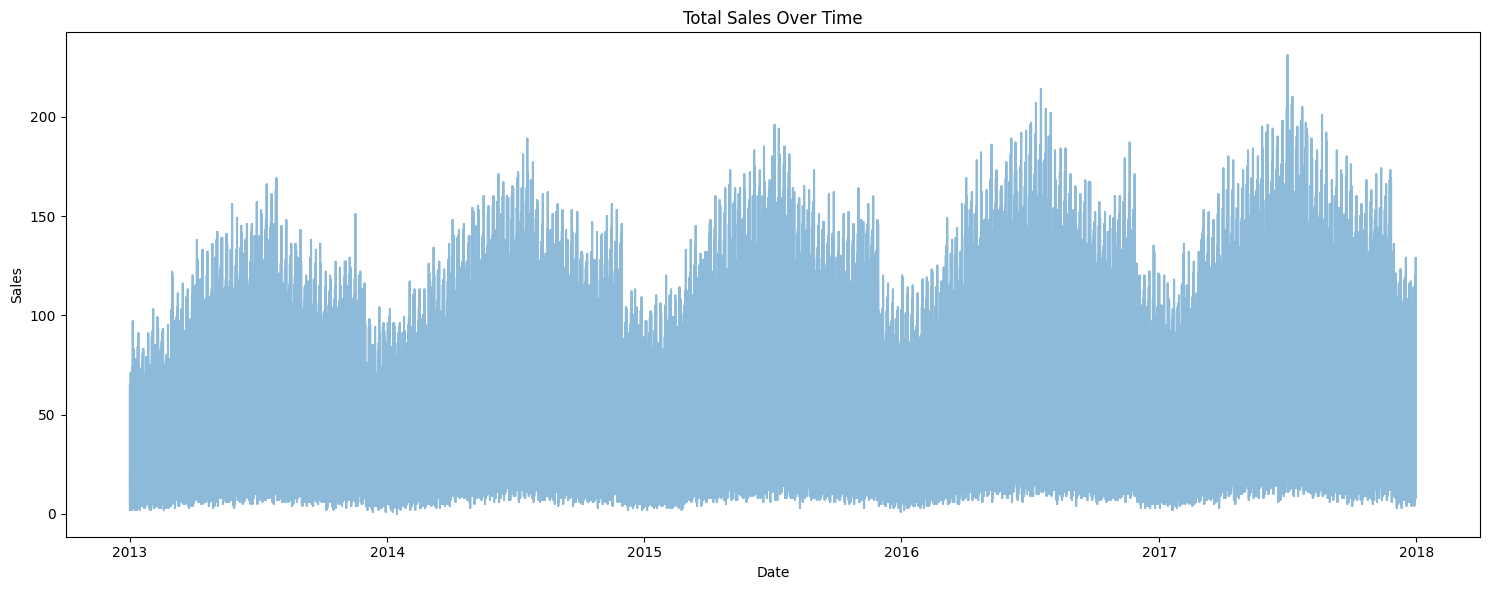

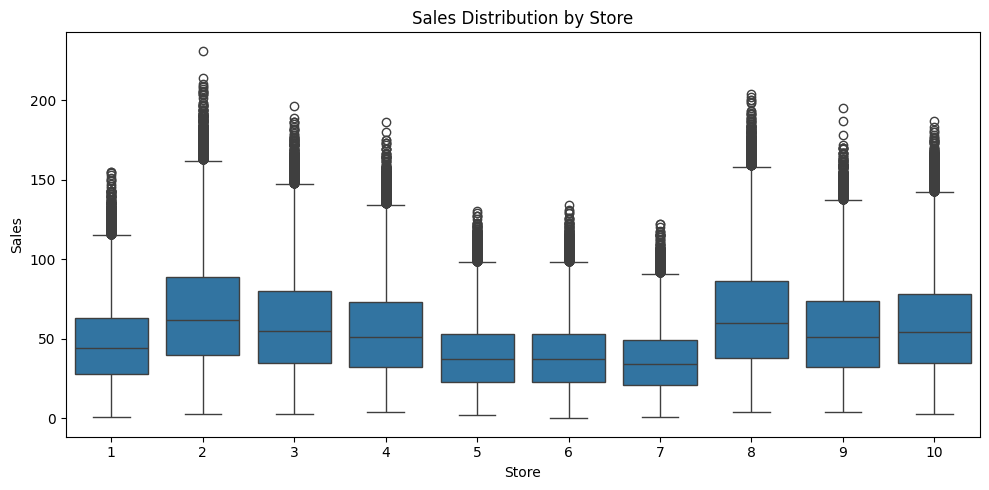

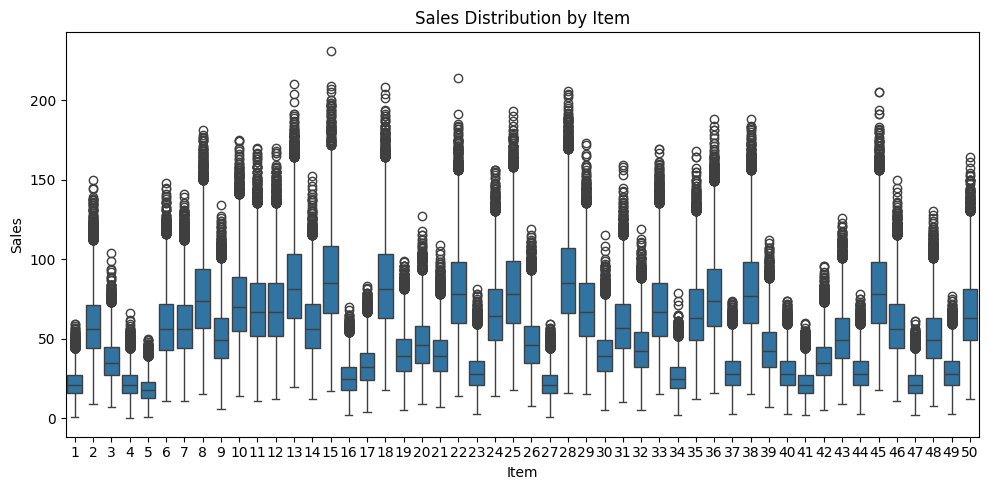

In [5]:
# Visualization of df_train
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
plt.plot(df_train['date'], df_train['sales'], alpha=0.5)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='store', y='sales', data=df_train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='item', y='sales', data=df_train)
plt.title('Sales Distribution by Item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


# 4. Train-Test Split

In [6]:
# Define features and target
features = ['store_encoded', 'item_encoded']
target = 'sales'

# Sort by date to ensure chronological split
df_train_sorted = df_train.sort_values('date')

# Split the data: test set = 45000, rest is train
test_size = 45000
train_data = df_train_sorted.iloc[:-test_size]
test_data = df_train_sorted.iloc[-test_size:]

# Prepare X and y for each split
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (868000, 2)
Test set shape: (45000, 2)


# 5. Feature Engineering

In [10]:
# Advanced Feature Engineering สำหรับ Train-Test Split

def create_time_features(df):
    """Create time-based features from date column"""
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['week_of_year'] = df['date'].dt.isocalendar().week
    return df

def create_lag_features(df, lags=[7, 14, 30, 60]):
    """Create lagged features for sales"""
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)
    return df

def create_rolling_features(df, windows=[7, 14, 30, 60]):
    """Create rolling statistics features"""
    for window in windows:
        df[f'sales_rolling_mean_{window}'] = df.groupby(['store', 'item'])['sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        df[f'sales_rolling_std_{window}'] = df.groupby(['store', 'item'])['sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std())
        df[f'sales_rolling_min_{window}'] = df.groupby(['store', 'item'])['sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).min())
        df[f'sales_rolling_max_{window}'] = df.groupby(['store', 'item'])['sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).max())
    return df

def create_interaction_features(df):
    """Create interaction features between store and item"""
    df['store_item_avg'] = df.groupby(['store', 'item'])['sales'].transform('mean')
    df['store_avg'] = df.groupby('store')['sales'].transform('mean')
    df['item_avg'] = df.groupby('item')['sales'].transform('mean')
    return df

# ใช้ feature engineering กับ train_data และ test_data
for dataset in [train_data, test_data]:
    create_time_features(dataset)
    create_lag_features(dataset)
    create_rolling_features(dataset)
    create_interaction_features(dataset)

# กำหนดกลุ่มฟีเจอร์
time_features = ['year', 'month', 'day', 'day_of_week', 'quarter', 
                'is_weekend', 'is_month_start', 'is_month_end', 'week_of_year']
lag_features = [f'sales_lag_{lag}' for lag in [7, 14, 30, 60]]
rolling_features = []
for window in [7, 14, 30, 60]:
    rolling_features.extend([
        f'sales_rolling_mean_{window}',
        f'sales_rolling_std_{window}',
        f'sales_rolling_min_{window}',
        f'sales_rolling_max_{window}'
    ])
interaction_features = ['store_item_avg', 'store_avg', 'item_avg']

# รวมฟีเจอร์ทั้งหมด
features = ['store_encoded', 'item_encoded'] + time_features + lag_features + rolling_features + interaction_features

# เตรียม X, y สำหรับแต่ละชุด
X_train = train_data[features]
y_train = train_data['sales']

X_test = test_data[features]
y_test = test_data['sales']

# จัดการ missing values
for col in X_train.columns:
    if X_train[col].isnull().any():
        if col.startswith('sales_lag') or col.startswith('sales_rolling'):
            X_train[col] = X_train[col].fillna(method='ffill').fillna(method='bfill')
            X_test[col] = X_test[col].fillna(method='ffill').fillna(method='bfill')
        else:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)

# แสดงสรุปกลุ่มฟีเจอร์
print("\nFeature Groups Summary:")
print(f"Time features: {len(time_features)}")
print(f"Lag features: {len(lag_features)}")
print(f"Rolling features: {len(rolling_features)}")
print(f"Interaction features: {len(interaction_features)}")
print(f"Total features: {len(features)}")


Feature Groups Summary:
Time features: 9
Lag features: 4
Rolling features: 16
Interaction features: 3
Total features: 34


# 6. Model Development


In [ ]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
from itertools import product
import joblib

# ---------- STEP 1: Evaluate Function ----------
def evaluate_predictions(y_true, y_pred, prefix=''):
    metrics = {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    print(f"\n{prefix} Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    return metrics

# ---------- STEP 2: Parameter Grid ----------
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}

# ---------- STEP 3: Scale Data ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- STEP 4: TimeSeriesSplit ----------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
val_indices = list(tscv.split(X_train_scaled))[-1][1]
train_indices = list(tscv.split(X_train_scaled))[-1][0]
X_train_cv, y_train_cv = X_train_scaled[train_indices], y_train.iloc[train_indices]
X_val_scaled, y_val = X_train_scaled[val_indices], y_train.iloc[val_indices]

# ---------- STEP 5: Grid Search ----------
print("\nTuning hyperparameters for LightGBM with TimeSeriesSplit...")
keys, values = zip(*param_grid.items())
best_rmse = float('inf')
best_model = None
best_param = None

for v in product(*values):
    params = dict(zip(keys, v))
    rmses = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
        X_tr, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=30),
                lgb.log_evaluation(period=0)
            ]
        )
        val_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
        rmses.append(rmse)

    avg_rmse = np.mean(rmses)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model = lgb.LGBMRegressor(**params)
        best_model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_val_scaled, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=30),
                lgb.log_evaluation(period=0)
            ]
        )
        best_param = params

print(f"\nBest params for LightGBM: {best_param}, CV RMSE: {best_rmse:.4f}")

# ---------- STEP 6: Evaluate on Hold-Out Validation ----------
val_pred = best_model.predict(X_val_scaled)
metrics = evaluate_predictions(y_val, val_pred, prefix="LightGBM")

# ---------- STEP 7: Feature Importance ----------
features = X_train.columns  # Ensure X_train is a DataFrame
importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 important features for LightGBM:")
print(importance.head(10))

# ---------- STEP 8: Save Model & Scaler ----------
joblib.dump(best_model, 'best_model_LightGBM.joblib')
joblib.dump(scaler, 'feature_scaler.joblib')



Tuning hyperparameters for LightGBM with TimeSeriesSplit...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4132
[LightGBM] [Info] Number of data points in the train set: 144670, number of used features: 33
[LightGBM] [Info] Start training from score 44.447059
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 38.5763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4313
[LightGBM] [Info] Number of data points in the train set: 289336, number of used features: 34
[LightGBM] [Info] Start training from score 46.031807
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]

# 7. Visualization


In [ ]:
# 7. Visualization for LightGBM 

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# --- สร้าง prediction ของ LightGBM บน X_test_scaled ---
test_pred = best_model.predict(X_test_scaled)

# --- สร้าง dict predictions (ใช้ชื่อว่า 'LightGBM') ---
test_predictions = {
    'LightGBM': test_pred
}

# --- ฟังก์ชันวาดกราฟ Time Series ---
def plot_time_series(actual, predictions, dates):
    fig = go.Figure()

    # Actual
    fig.add_trace(go.Scatter(
        x=dates,
        y=actual,
        name='Actual',
        line=dict(color='blue', width=2)
    ))

    # Prediction
    fig.add_trace(go.Scatter(
        x=dates,
        y=predictions['LightGBM'],
        name='LightGBM',
        line=dict(color='red', width=2, dash='dash')
    ))

    fig.update_layout(
        height=500,
        title='Time Series Plot: LightGBM Sales Prediction',
        xaxis_title='Date',
        yaxis_title='Sales',
        xaxis=dict(
            tickformat='%b %d\n%Y',
            tickmode='auto',
            nticks=10
        ),
        showlegend=True,
        hovermode='x unified'
    )

    fig.show()

# --- ฟังก์ชันวาดกราฟ Scatter + Histogram ---
def plot_analysis(actual, predictions):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Scatter Plot: Actual vs Predicted', 
                                        'Distribution Plot'))

    # Scatter: Actual vs Predicted
    fig.add_trace(go.Scatter(
        x=actual,
        y=predictions['LightGBM'],
        mode='markers',
        name='Actual vs Predicted',
        marker=dict(color='green', size=5, opacity=0.6)
    ), row=1, col=1)

    # เส้น y = x (สมบูรณ์แบบ)
    min_val = min(min(actual), min(predictions['LightGBM']))
    max_val = max(max(actual), max(predictions['LightGBM']))
    fig.add_trace(go.Scatter(
        x=[min_val, max_val],
        y=[min_val, max_val],
        mode='lines',
        name='Perfect Prediction',
        line=dict(color='red', dash='dash')
    ), row=1, col=1)

    # Histogram
    fig.add_trace(go.Histogram(
        x=actual,
        name='Actual',
        opacity=0.6,
        nbinsx=30
    ), row=1, col=2)

    fig.add_trace(go.Histogram(
        x=predictions['LightGBM'],
        name='Predicted',
        opacity=0.6,
        nbinsx=30
    ), row=1, col=2)

    # Layout
    fig.update_layout(
        height=450,
        showlegend=True,
        hovermode='x unified'
    )

    fig.update_xaxes(title_text='Actual Sales', row=1, col=1)
    fig.update_yaxes(title_text='Predicted Sales', row=1, col=1)
    fig.update_xaxes(title_text='Sales Value', row=1, col=2)
    fig.update_yaxes(title_text='Count', row=1, col=2)

    fig.show()

# --- เรียก plot ---
plot_time_series(y_test, test_predictions, test_data['date'])
plot_analysis(y_test, test_predictions)


# 8. Model Evaluation - Overfitting Analysis


Validation Metrics:
--------------------------------------------------
LightGBM:
  RMSE: 6.5336
  R2: 0.9587

Test Set Metrics:
--------------------------------------------------
LightGBM:
  RMSE: 6.4498
  R2: 0.9486

Overfitting Analysis:
--------------------------------------------------
Validation RMSE: 6.5336
Test RMSE: 6.4498
การวิเคราะห์:
✅ Good fit: Validation และ Test ใกล้เคียงกัน


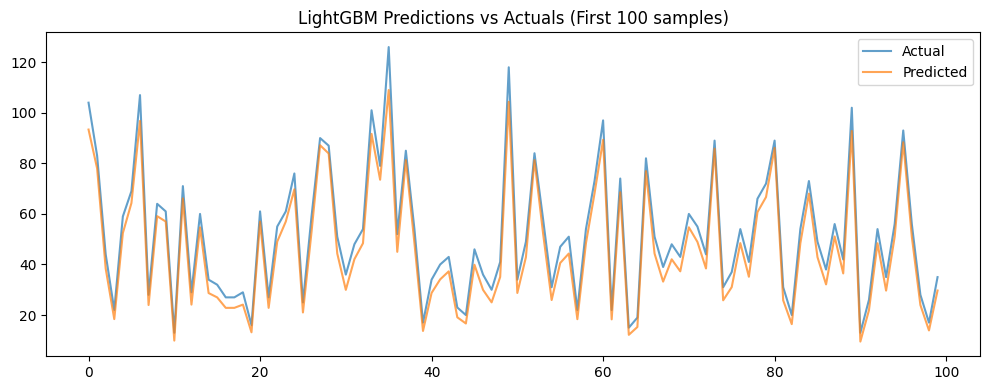

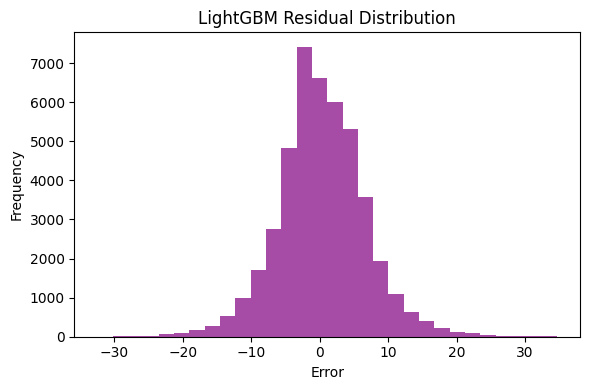


Model Performance Summary:
--------------------------------------------------
      Model         Set      RMSE        R2
0  LightGBM  Validation  6.533640  0.958722
1  LightGBM        Test  6.449785  0.948595

📌 สรุปผลการวิเคราะห์:
--------------------------------------------------
โมเดลที่ดีที่สุด: LightGBM
1. ความแตกต่างระหว่าง Validation RMSE และ Test RMSE: 1.28%
2. Test R² Score: 0.9486
3. การกระจายของ Residuals: สมมาตรใกล้เคียง Normal Distribution
4. ข้อเสนอแนะ:


In [16]:
# 8. Model Evaluation - Overfitting Analysis for LightGBM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ----- 1. เปรียบเทียบ Metrics บน Validation และ Test -----
print("Validation Metrics:")
print("-" * 50)
val_pred = best_model.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_r2 = r2_score(y_val, val_pred)
print(f"LightGBM:")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R2: {val_r2:.4f}\n")

print("Test Set Metrics:")
print("-" * 50)
test_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)
print(f"LightGBM:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R2: {test_r2:.4f}")

# ----- 2. ตรวจ Overfitting/Underfitting -----
print("\nOverfitting Analysis:")
print("-" * 50)
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print("การวิเคราะห์:")
if val_rmse < test_rmse * 0.8:
    print("⚠️ Overfitting: Validation ดีมาก แต่ Test แย่กว่ามาก")
elif val_rmse > test_rmse * 1.2:
    print("⚠️ Underfitting: Validation score แย่ตั้งแต่แรก")
else:
    print("✅ Good fit: Validation และ Test ใกล้เคียงกัน")

# ----- 3. วาดกราฟเปรียบเทียบ -----
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='Actual', alpha=0.7)
plt.plot(test_pred[:100], label='Predicted', alpha=0.7)
plt.title("LightGBM Predictions vs Actuals (First 100 samples)")
plt.legend()
plt.tight_layout()
plt.show()

# ----- 4. Distribution ของ residuals -----
residuals = y_test - test_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.title("LightGBM Residual Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ----- 5. สรุปเป็นตาราง -----
summary_df = pd.DataFrame([
    {'Model': 'LightGBM', 'Set': 'Validation', 'RMSE': val_rmse, 'R2': val_r2},
    {'Model': 'LightGBM', 'Set': 'Test', 'RMSE': test_rmse, 'R2': test_r2}
])
print("\nModel Performance Summary:")
print("-" * 50)
print(summary_df)

# ----- 6. สรุปผลการวิเคราะห์ -----
print("\n📌 สรุปผลการวิเคราะห์:")
print("-" * 50)
rmse_diff_percent = abs(val_rmse - test_rmse) / val_rmse * 100
print("โมเดลที่ดีที่สุด: LightGBM")
print(f"1. ความแตกต่างระหว่าง Validation RMSE และ Test RMSE: {rmse_diff_percent:.2f}%")
print(f"2. Test R² Score: {test_r2:.4f}")
print(f"3. การกระจายของ Residuals: {'สมมาตรใกล้เคียง Normal Distribution' if abs(np.mean(residuals)) < np.std(residuals) else 'มีความเบ้'}")

print("4. ข้อเสนอแนะ:")
if rmse_diff_percent > 20:
    print("   - ควรพิจารณาปรับ hyperparameters หรือลดความซับซ้อนของโมเดล")
    print("   - อาจใช้เทคนิค regularization เพิ่มเติม")
if abs(np.mean(residuals)) > np.std(residuals):
    print("   - ควรตรวจสอบ feature engineering หรือเพิ่ม features ที่เกี่ยวข้อง")
if test_r2 < 0.7:
    print("   - อาจต้องพิจารณาเพิ่ม features หรือทดลองโมเดลประเภทอื่น")


# 9. Future Sales Prediction (3 Months)


In [21]:
# 9. Future Sales Prediction (3 Months) - สำหรับ LightGBM เท่านั้น

import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ----- STEP 1: เตรียมข้อมูลอนาคต -----
df_future = df_test.copy()  # df_test ควรมี 'date', 'store', 'item', 'sales' (หรือ sales = NaN ก็ได้)

# ----- STEP 2: สร้างฟีเจอร์เวลา (เช่น day, month, weekday) -----
df_future = create_time_features(df_future)  # ฟังก์ชันเดียวกับตอนเทรน

# ----- STEP 3: สร้าง lag และ rolling mean (เฉพาะที่เคยใช้ตอนเทรน) -----
last_known_sales = df_train.groupby(['store', 'item'])['sales'].last().reset_index()
df_future = df_future.merge(last_known_sales, on=['store', 'item'], how='left', suffixes=('', '_last'))

# สร้าง lag features
for lag in [7, 14, 30, 60]:
    df_future[f'sales_lag_{lag}'] = df_future.groupby(['store', 'item'])['sales'].shift(lag)

# สร้าง rolling features (เฉพาะ rolling mean, ถ้ามี std/min/max เพิ่มเติมก็บอกได้)
for window in [7, 14, 30, 60]:
    df_future[f'sales_rolling_mean_{window}'] = df_future.groupby(['store', 'item'])['sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

# สร้าง aggregated features ที่อาจเคยใช้
df_future['store_item_avg'] = df_future.groupby(['store', 'item'])['sales'].transform('mean')
df_future['store_avg'] = df_future.groupby(['store'])['sales'].transform('mean')
df_future['item_avg'] = df_future.groupby(['item'])['sales'].transform('mean')

# ----- STEP 4: เลือกเฉพาะฟีเจอร์ที่มีอยู่ใน df_future -----
available_features = [f for f in features if f in df_future.columns]
X_future = df_future[available_features].copy()
X_future = X_future.fillna(X_future.mean())

# ----- STEP 5: Scale ด้วย scaler เดิม -----
X_future_scaled = scaler.transform(X_future)

# ----- STEP 6: ทำนายด้วยโมเดล LightGBM -----
future_pred = best_model.predict(X_future_scaled)

# ----- STEP 7: แสดงผลกราฟรวมอดีต-อนาคต -----
def plot_full_predictions(train_data, future_data, future_pred):
    fig = go.Figure()

    # อดีต
    fig.add_trace(go.Scatter(
        x=train_data['date'],
        y=train_data['sales'],
        name='Historical Sales',
        line=dict(color='blue', width=2)
    ))

    # อนาคต
    fig.add_trace(go.Scatter(
        x=future_data['date'],
        y=future_pred,
        name='Future Prediction (LightGBM)',
        line=dict(color='red', width=2, dash='dash')
    ))

    # เส้นแบ่งเวลา
    prediction_start = train_data['date'].max()
    fig.add_shape(
        type="line",
        x0=prediction_start,
        y0=0,
        x1=prediction_start,
        y1=train_data['sales'].max(),
        line=dict(color="gray", width=2, dash="dash")
    )

    fig.add_annotation(
        x=prediction_start,
        y=train_data['sales'].max(),
        text="Prediction Start",
        showarrow=True,
        arrowhead=1
    )

    # Layout
    fig.update_layout(
        height=600,
        title='Historical Sales and 3-Month Forecast (LightGBM)',
        xaxis_title='Date',
        yaxis_title='Sales',
        xaxis=dict(
            tickformat='%b %d\n%Y',
            tickmode='auto',
            nticks=15
        ),
        showlegend=True,
        hovermode='x unified'
    )

    fig.show()

# ----- STEP 8: เรียกใช้งาน -----
plot_full_predictions(df_train, df_future, future_pred)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- sales_rolling_max_14
- sales_rolling_max_30
- sales_rolling_max_60
- sales_rolling_max_7
- sales_rolling_min_14
- ...
